In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [2]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [3]:
scale(9)

tensor(6.9981)

In [4]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [5]:
conditioned_scale(9)

9.5

In [6]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)

In [7]:
deferred_conditioned_scale(9.5, 3)

9.5

In [8]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)

In [10]:
scale_obs(9)

9.5

In [11]:
def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [12]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

a =  9.181012153625488
b =  0.6078652143478394


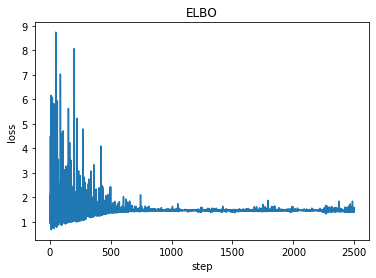

In [58]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())

losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

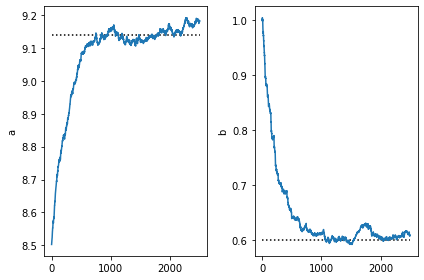

In [59]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [131]:
samples01 = torch.tensor([perfect_guide(guess) for i in range(10000)])

samples01.mean(), samples01.std()

(tensor(9.1408), tensor(0.5969))

In [130]:
samples02 = torch.tensor([scale_parametrized_guide_constrained(guess) for i in range(10000)])


samples02.mean(), samples02.std()


(tensor(8.5108), tensor(1.0030))

In [142]:
imp = pyro.infer.Importance(
    model=conditioned_scale,
    guide=scale_parametrized_guide_constrained, num_samples=30000)

In [143]:
pyro.clear_param_store()

In [144]:
infm2 = imp.run(guess)

In [145]:
len(infm2.exec_traces)

30000

In [146]:
infm2.get_ESS()

tensor(18110.2715)

In [147]:
pyro.get_param_store().named_parameters()

dict_items([('a', tensor(8.5000, requires_grad=True)), ('b', tensor(0., requires_grad=True))])

In [148]:
samples03 = torch.tensor([tr.nodes["weight"]["value"] for tr in infm2.exec_traces])

In [149]:
samples03.mean(), samples03.std()

(tensor(8.5109), tensor(1.0019))

In [57]:
pyro.param("a")

tensor(8.5000, requires_grad=True)

In [30]:
infm2.exec_traces[1].compute_log_prob()

In [34]:
pyro.get_param_store().get_all_param_names()

dict_keys([])